In [1]:
# Source: https://github.com/alan-turing-institute/sktime/blob/main/examples/01_forecasting.ipynb
# Source: https://www.kaggle.com/nageshsingh/stock-market-forecasting-arima
# Source: https://www.kaggle.com/mtszkw/xgboost-for-stock-trend-prices-prediction

from warnings import simplefilter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mplfinance as fplt

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# from sktime.forecasting.arima import ARIMA, AutoARIMA
# from sktime.forecasting.base import ForecastingHorizon
# from sktime.forecasting.compose import (
#     EnsembleForecaster,
#     ReducedForecaster,
#     TransformedTargetForecaster,
# )
# from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# from sktime.forecasting.model_selection import (
#     ExpandingWindowSplitter,
#     ForecastingGridSearchCV,
#     SlidingWindowSplitter,
# )
# from sktime.forecasting.naive import NaiveForecaster
# from sktime.forecasting.theta import ThetaForecaster
# from sktime.forecasting.trend import PolynomialTrendForecaster
# from sktime.performance_metrics.forecasting import sMAPE, smape_loss
# from sktime.transformations.series.detrend import Deseasonalizer, Detrender
# from sktime.utils.plotting import plot_series

from sklearn.model_selection import TimeSeriesSplit

from pylab import rcParams
rcParams['figure.figsize'] = 10,6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL

import math

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
py.offline.init_notebook_mode()

# Analyzing Apple Stock

1. Load Apple Stock data and drop unneeded columns -> We will focus on the closing price as the label to predict
2. Visualize the closing price of the stock over the entire data set.
3. Ensure there are no missing values in the series. If so, fill them appropriately.
3. Is the stock stationary?
    * To do this, we can do a Augment Dickey -Fuller Test that determines if there is a unit root in the series
    To read more: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
4. Separate out seasonality and trend to observe changes in stock price

# Features

We will engineer our own features based on the available data. We will use a variety of features however most will be
based around well known technical indicators such as moving average, exponential moving averages, momentum, Bollinger
Bands, Price volume Trend etc. For a more exhaustive list, please view the report at TODO

### ADF (Augmented Dickey-Fuller) Test

This will help us determine if there is a unit root in our time series (indicating stationary vs non-stationary)

Stationary Time Series: A time series whose properties do not depend on the time at which the series is observed. I.e
time series with trends or seasonality are not stationary. This is relevant as this will dictate how we select features
or engineer them as well as inform our algorithms.

In order to effectively predict a time series, we must make it stationary by removing trend and seasonality from it.
A stationary series will be roughly horizontal over the long term. Our goal is to use machine learning to predict this.

Null Hypothesis: The series has a unit root.
Alternative Hypothesis: The series has no unit root.

If null hypothesis is not rejected, we can that the series is non-stationary.

## Feature Engineering

We will create several engineered features which will be used for our prediction:

1. Exponential moving average (9, 5 and 35 days)
2. Standard moving average (5, 10, 15, 30 days)
3. RSI - Relative strength index
4. MACD - Momentum indicator

In [4]:
def preprocess_data(df_stock, date_range=('2007-01-01', '2021-01-01')):
    # sets the dataframe so it is indexed by date instead of integers
    df_stock.index = pd.to_datetime(df_stock.index)
    
    # Drop unneeded column
    df_stock.drop(columns='OpenInt', inplace=True)
    
    # Check if we have any missing values
    print(f'Number of Missing Values: {df_stock.isnull().sum()}')
    
    # Set up our date range for the data. By default, it starts at 2007 and ends at 01 Jan 2021
    df_stock = df_stock.loc[date_range[0]:date_range[1]]
    
    # Rearrange the columns for easier manipulation later:
    df_stock = df_stock[['Close', 'Open', 'High', 'Low', 'Volume']]
    
    return df_stock
    
# Relative Strength Index: Momentum indicator that measures the magnitude of the prices changes to see if a share is
# overbought or sold. Values lie between 0 and 100. If a value is above 70 indicates overbought or overvalued while
# below 30 indicates oversold or undervalued.

# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
def calculate_rsi(df, period=14):
    delta = df['Close'].diff()

    dUp = delta.copy()
    dDown = delta.copy()

    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    rollUP = dUp.rolling(period).mean()
    rollDOWN = dDown.abs().rolling(period).mean()

    rs = rollUP/rollDOWN

    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

def create_indicators(df, dropnan = True):
    # Create a copy of the dataset to not touch the original 
    df_stock = df.copy()
    
    # Moving averages:
    # Exponential moving average with a different spans 
    # Additional info: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
    df_stock['EMA_5'] = df_stock['Close'].ewm(span=5, min_periods=5).mean()
    df_stock['EMA_9'] = df_stock['Close'].ewm(span=9, min_periods=9).mean()
    df_stock['EMA_35'] = df_stock['Close'].ewm(span=35, min_periods=35).mean()


    # These are standard moving averages. They do not take into account any history of the closing price beyond what is
    # explicitly within the window specified within the rolling() function.
    df_stock['SMA_5'] = df_stock['Close'].rolling(5).mean()
    df_stock['SMA_10'] = df_stock['Close'].rolling(10).mean()
    df_stock['SMA_15'] = df_stock['Close'].rolling(15).mean()
    df_stock['SMA_30'] = df_stock['Close'].rolling(30).mean()
    
    df_stock['RSI'] = calculate_rsi(df_stock)
    
    EMA_12 = df_stock['Close'].ewm(span=12).mean()
    EMA_26 = df_stock['Close'].ewm(span=26).mean()

    df_stock['MACD'] = EMA_26 - EMA_12
    df_stock['MACD_Signal'] = df_stock['MACD'].ewm(span=9, min_periods=9).mean()
    
    # remove NA rows:
    if dropnan:
        df_stock.dropna(inplace=True)

    return df_stock

def reshape_timeseries(df, time_steps_in, time_steps_out, dropnan=True):
    # Create a copy to not change the original dataframe accidentally 
    df_stock = df.copy()
    
    # Our objective is reshape our data set so it is suitable for our lstm
    # LSTMS expect the input data to be in this shape [samples, timesteps, features]
    # so 3d data with the one axis being number of steps in time we are looking back to make
    # a forecast
    
    # time_steps_in: number of time steps in the past to look
    # time_steps_out: number of time steps ahead to predict
    
    # we assume that the date column has been removed or added as the indexer
    variable_count = df_stock.shape[1]
    
    columns_current = list(df_stock.columns)
    cols = list()
    names = list()
    
    # here we add past observations as new columns! this will be used as input
    for i in range(time_steps_in, 0, -1): # go in reverse-> counting down
        cols.append(df_stock.shift(i))
        names += [f'{col_name}(t-{i})' for col_name in columns_current]
   
    # here we move t+1 -> ie future observations -> These will be used as output. 
    for i in range(0, time_steps_out):
        cols.append(df_stock.shift(-i))
        if i == 0:
            names += [f'{col_name}(t)' for col_name in columns_current]
        else:
            names += [f'{col_name}(t+{i})' for col_name in columns_current]
            
    aggregated_df = pd.concat(cols, axis=1)
    aggregated_df.columns = names
    
    if dropnan:
        aggregated_df.dropna(inplace=True)
        
    return aggregated_df
    

In [5]:
# LOAD DATA SET

STOCK_NAME = 'AAPL'

df_stock = pd.read_csv(f'data_files/Stocks/{STOCK_NAME.lower()}.us.txt', index_col=0)

# Preprocess our data set for some initial cleaning. 
df_stock = preprocess_data(df_stock)

# Add indicators to our data:
df_stock_w_indicators = create_indicators(df_stock, dropnan=True)

Number of Missing Values: Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [6]:
# Visualize original Dataframe
df_stock.head()

Close    Open    High     Low     Volume
Date                                                 
2007-01-03  10.731  11.049  11.087  10.486  345302870
2007-01-04  10.969  10.780  11.007  10.733  236252357
2007-01-05  10.893  10.992  11.038  10.807  232773093
2007-01-08  10.946  11.011  11.081  10.922  222149027
2007-01-09  11.854  11.075  11.907  10.906  933759387

In [7]:
# Visualize preprocessed Dataframe
df_stock_w_indicators

Close     Open     High      Low     Volume       EMA_5  \
Date                                                                    
2007-02-22   11.463   11.628   11.630   11.335  233763003   11.213086   
2007-02-23   11.407   11.433   11.569   11.378  144427846   11.277724   
2007-02-26   11.352   11.507   11.526   11.220  171792585   11.302483   
2007-02-27   10.748   11.048   11.150   10.683  319442902   11.117655   
2007-02-28   10.834   10.828   10.961   10.629  256409965   11.023103   
...             ...      ...      ...      ...        ...         ...   
2017-11-06  173.630  171.750  174.360  171.100   34901241  169.605323   
2017-11-07  174.180  173.290  174.510  173.290   24424877  171.130215   
2017-11-08  175.610  174.030  175.610  173.710   24451166  172.623477   
2017-11-09  175.250  174.480  175.460  172.520   29533086  173.498984   
2017-11-10  174.670  175.110  175.380  174.270   25130494  173.889323   

                 EMA_9      EMA_35     SMA_5    SMA_10      SMA_15  \
Date                                                                 
2007-02-22   11.104942   11.098846   11.1324   11.0002   10.951000   
2007-02-23   11.165373   11.118473   11.2314   11.0373   10.988000   
2007-02-26   11.202708   11.133227   11.3292   11.1061   11.021333   
2007-02-27   11.111748   11.109073   11.2788   11.0939   11.021200   
2007-02-28   11.056189   11.091948   11.1608   11.0927   11.025000   
...                ...         ...       ...       ...         ...   
2017-11-06  166.708798  160.168354  169.5480  164.5570  162.092000   
2017-11-07  168.203038  160.946779  170.6980  166.3210  163.044000   
2017-11-08  169.684431  161.761402  172.5620  168.2970  164.138667   
2017-11-09  170.797544  162.510769  174.1100  170.1370  165.460667   
2017-11-10  171.572036  163.186282  174.6680  171.3570  166.726000   

                SMA_30        RSI      MACD  MACD_Signal  
Date                                                      
2007-02-22   11.217133  67.669173  0.005113     0.077706  
2007-02-23   11.183367  65.546218 -0.020337     0.058091  
2007-02-26   11.152867  67.318757 -0.035861     0.039296  
2007-02-27   11.107233  49.373650 -0.001789     0.031077  
2007-02-28   11.053933  45.386766  0.018350     0.028531  
...                ...        ...       ...          ...  
2017-11-06  158.380667  74.079270 -3.806569    -2.161603  
2017-11-07  159.100333  76.437390 -4.245416    -2.578366  
2017-11-08  159.831333  88.811995 -4.654936    -2.993680  
2017-11-09  160.582000  87.471264 -4.894020    -3.373748  
2017-11-10  161.285333  85.827068 -4.979296    -3.694857  

[2702 rows x 15 columns]

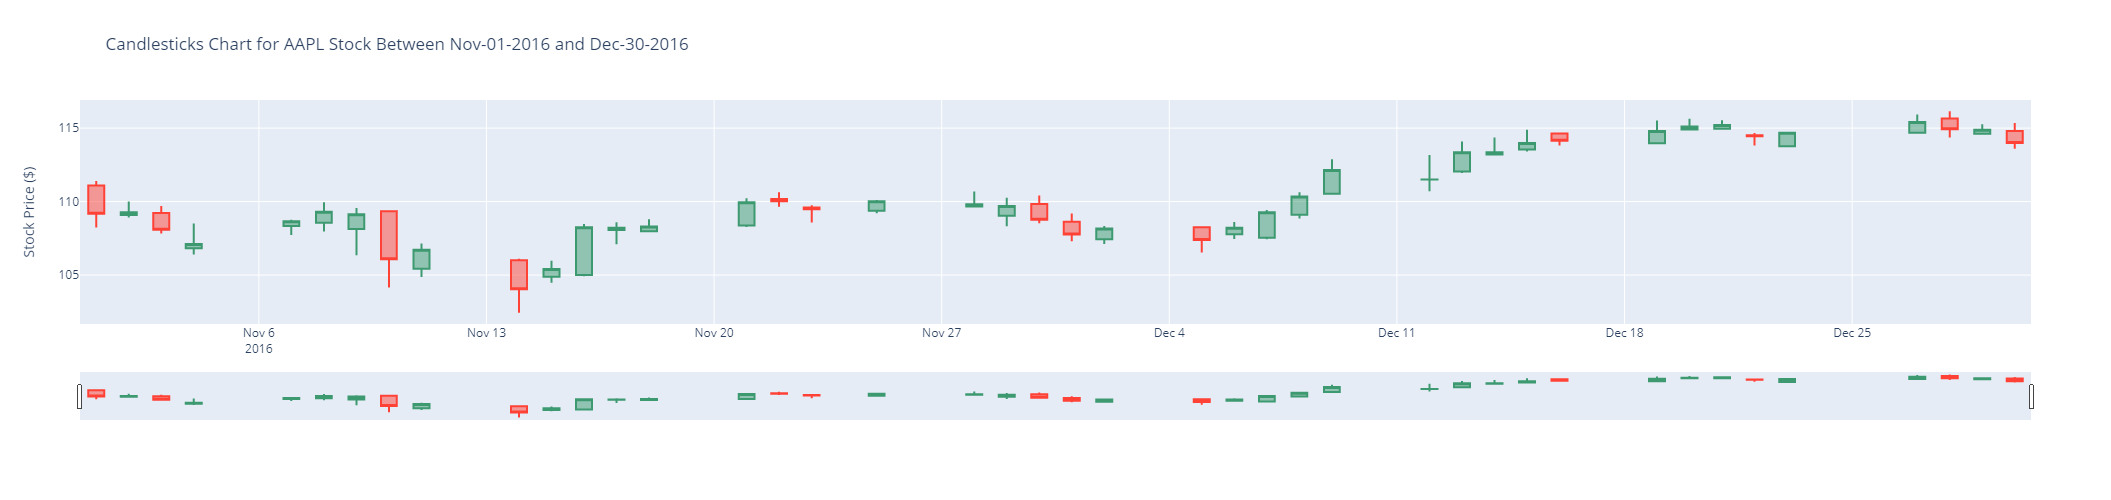

In [8]:
# Show basic information about the stock:
df_stock_last_month = df_stock.loc['2016-11-01':'2016-12-31']
candlestick = go.Candlestick(
    x=df_stock_last_month.index,
    open=df_stock_last_month['Open'],
    close=df_stock_last_month['Close'],
    high=df_stock_last_month['High'],
    low=df_stock_last_month['Low']
)

fig = go.Figure(data=[candlestick])

fig.update_layout(
    title=f'Candlesticks Chart for {STOCK_NAME} Stock Between {min(df_stock_last_month.index).strftime("%b-%d-%Y")} and {max(df_stock_last_month.index).strftime("%b-%d-%Y")}',
    yaxis_title='Stock Price ($)',
    height = 500,
    width = 800,
)
fig.show()
fig.write_image('candles-201.png')

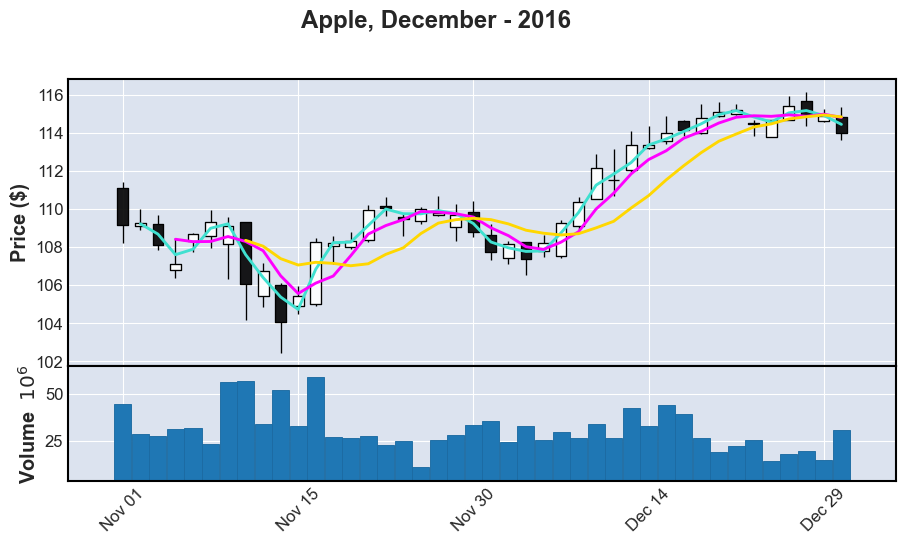

In [9]:
# Moving averages and candles!
# Lets plot for the last month of the data set:

fplt.plot(
    df_stock_last_month,
    type='candle',
    title='Apple, December - 2016',
    ylabel='Price ($)',
    volume = True,
    mav=(2,4,8),
    figratio=(20,10),
    # savefig='candles.png'
)

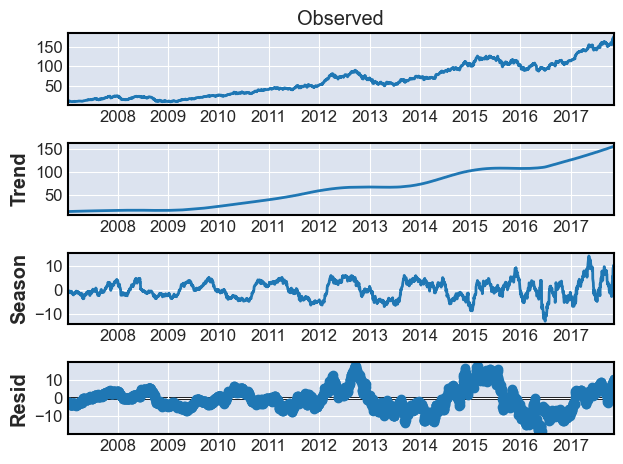

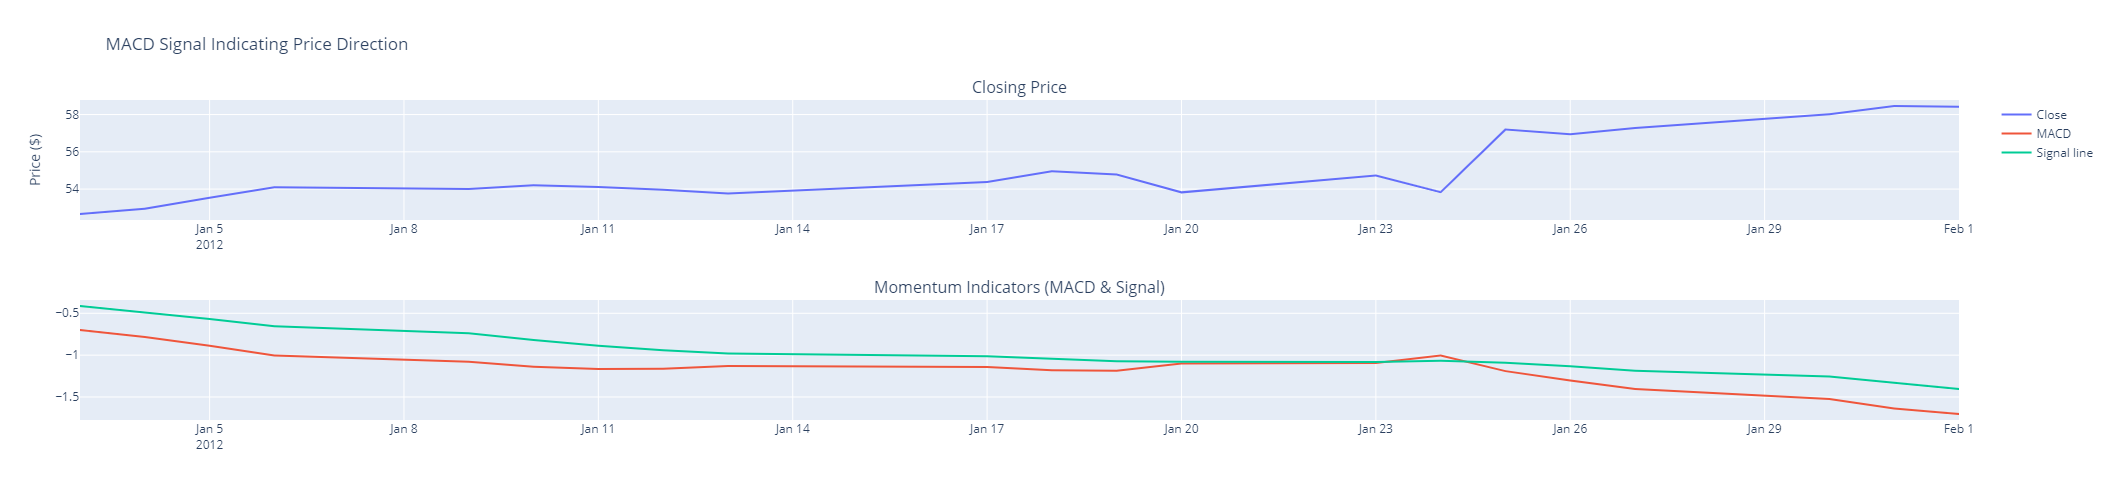

In [12]:
# Moving Average Convergence Divergence (MACD): Trend following momentum indicator that shows the relationship between
# two moving averages of the stock's prices. It is calculated by EMA(26) - EMA(12). This creates a MACD Line. A nine day
# EMA of the MACD called the signal line is then plotted on top of the MACD line. This can then be used an indicator for
# buy and sell signals.

# Buy when MACD crosses above the signal line. And sell when it cross below.

fig = make_subplots(rows=2, cols=1, subplot_titles = ('Closing Price', 'Momentum Indicators (MACD & Signal)'))

# Only use a small subsample of the date for easier visual analysis. 
df_visualize = df_stock_w_indicators.loc['2012-01-01':'2012-02-01']

fig.add_trace(go.Scatter(x=df_visualize.index, y=df_visualize.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df_visualize.index, y=df_visualize['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df_visualize.index, y=df_visualize['MACD_Signal'], name='Signal line'), row=2, col=1)

fig.update_layout(
    title='MACD Signal Indicating Price Direction',
    height = 500,
    width = 800,
)

fig.update_yaxes(title_text = 'Price ($)', row=1, col=1)


fig.write_image('figures/momentum-indicators.png')
fig.show()

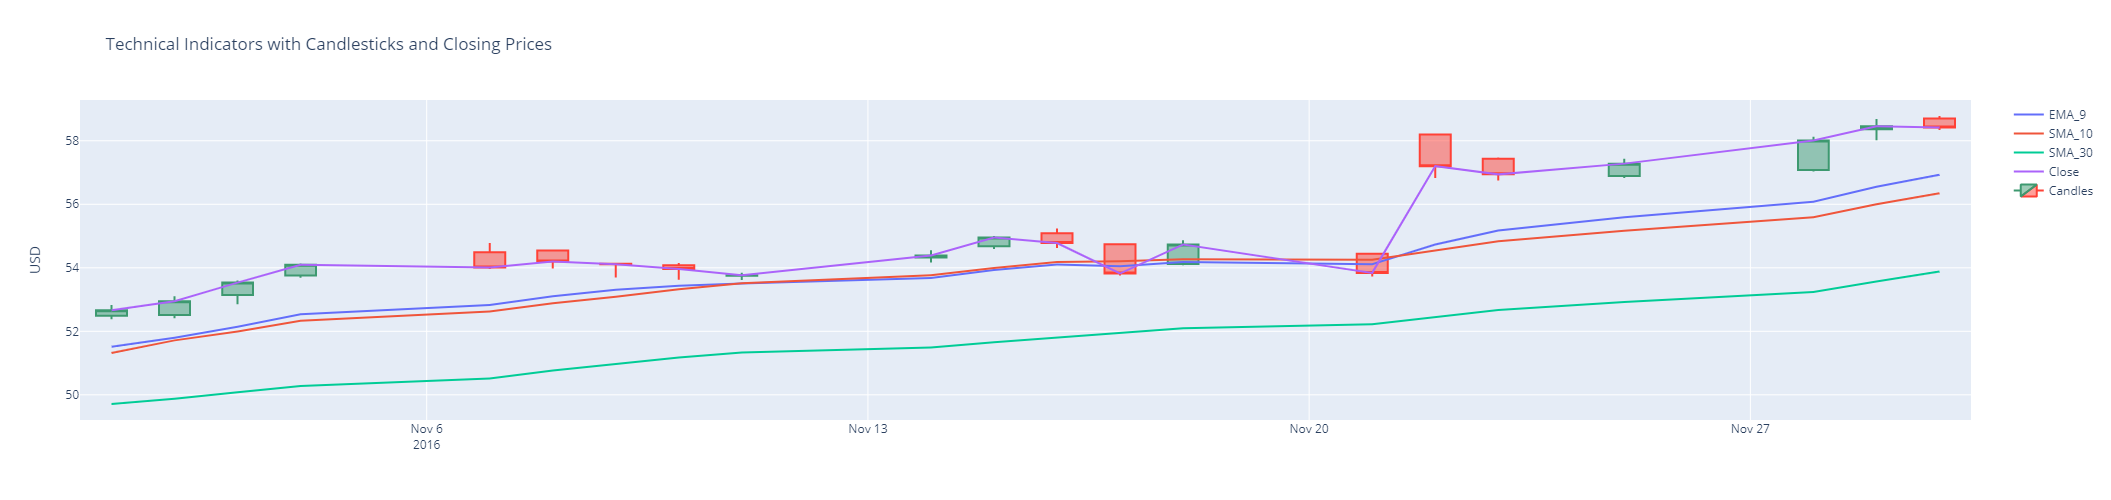

In [13]:
fig = go.Figure()


fig.add_trace(go.Scatter(x=df_stock_last_month.index, y=df_visualize.EMA_9, name='EMA_9'))
fig.add_trace(go.Scatter(x=df_stock_last_month.index, y=df_visualize.SMA_10, name='SMA_10'))
fig.add_trace(go.Scatter(x=df_stock_last_month.index, y=df_visualize.SMA_30, name='SMA_30'))
fig.add_trace(go.Scatter(x=df_stock_last_month.index, y=df_visualize.Close, name='Close'))
fig.add_trace(go.Candlestick(
    x=df_stock_last_month.index,
    open=df_visualize['Open'],
    close=df_visualize['Close'],
    high=df_visualize['High'],
    low=df_visualize['Low'],
    name='Candles'
))

fig.update_layout(
    title = 'Technical Indicators with Candlesticks and Closing Prices', 
    height = 500,
    width = 800,
    xaxis_rangeslider_visible=False
    
)

fig.update_yaxes(title='USD')
fig.write_image('indicators_with_candles.png')
fig.show()

In [14]:
df_stock_w_indicators

Close     Open     High      Low     Volume       EMA_5  \
Date                                                                    
2007-02-22   11.463   11.628   11.630   11.335  233763003   11.213086   
2007-02-23   11.407   11.433   11.569   11.378  144427846   11.277724   
2007-02-26   11.352   11.507   11.526   11.220  171792585   11.302483   
2007-02-27   10.748   11.048   11.150   10.683  319442902   11.117655   
2007-02-28   10.834   10.828   10.961   10.629  256409965   11.023103   
...             ...      ...      ...      ...        ...         ...   
2017-11-06  173.630  171.750  174.360  171.100   34901241  169.605323   
2017-11-07  174.180  173.290  174.510  173.290   24424877  171.130215   
2017-11-08  175.610  174.030  175.610  173.710   24451166  172.623477   
2017-11-09  175.250  174.480  175.460  172.520   29533086  173.498984   
2017-11-10  174.670  175.110  175.380  174.270   25130494  173.889323   

                 EMA_9      EMA_35     SMA_5    SMA_10      SMA_15  \
Date                                                                 
2007-02-22   11.104942   11.098846   11.1324   11.0002   10.951000   
2007-02-23   11.165373   11.118473   11.2314   11.0373   10.988000   
2007-02-26   11.202708   11.133227   11.3292   11.1061   11.021333   
2007-02-27   11.111748   11.109073   11.2788   11.0939   11.021200   
2007-02-28   11.056189   11.091948   11.1608   11.0927   11.025000   
...                ...         ...       ...       ...         ...   
2017-11-06  166.708798  160.168354  169.5480  164.5570  162.092000   
2017-11-07  168.203038  160.946779  170.6980  166.3210  163.044000   
2017-11-08  169.684431  161.761402  172.5620  168.2970  164.138667   
2017-11-09  170.797544  162.510769  174.1100  170.1370  165.460667   
2017-11-10  171.572036  163.186282  174.6680  171.3570  166.726000   

                SMA_30        RSI      MACD  MACD_Signal  
Date                                                      
2007-02-22   11.217133  67.669173  0.005113     0.077706  
2007-02-23   11.183367  65.546218 -0.020337     0.058091  
2007-02-26   11.152867  67.318757 -0.035861     0.039296  
2007-02-27   11.107233  49.373650 -0.001789     0.031077  
2007-02-28   11.053933  45.386766  0.018350     0.028531  
...                ...        ...       ...          ...  
2017-11-06  158.380667  74.079270 -3.806569    -2.161603  
2017-11-07  159.100333  76.437390 -4.245416    -2.578366  
2017-11-08  159.831333  88.811995 -4.654936    -2.993680  
2017-11-09  160.582000  87.471264 -4.894020    -3.373748  
2017-11-10  161.285333  85.827068 -4.979296    -3.694857  

[2702 rows x 15 columns]

## Prep our date for non-LSTM ML:

1. Add a new column which shifts the closing price by -1 -> one day ahead. This is what we will try to predict. 
2. Use ML algorithms and compare their performance to see which one does well. 

In [15]:
# Split up our data set in training, validation and test:
# Simple Splitting

# Add normal int indices:
df_stock_w_indicators = df_stock_w_indicators.reset_index()

df_stock_w_indicators['Close_Tomorrow'] = df_stock_w_indicators['Close'].shift(-1)
df_stock_w_indicators.dropna(inplace=True)

TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2
TRAIN_SIZE = 0.6

test_split_idx = int(len(df_stock_w_indicators) * (1-TEST_SIZE))
valid_split_idx = int(len(df_stock_w_indicators) * (1-VALIDATION_SIZE-TEST_SIZE))

train_df = df_stock_w_indicators.iloc[:valid_split_idx, :]
validation_df = df_stock_w_indicators.iloc[valid_split_idx:test_split_idx, :]
test_df = df_stock_w_indicators.iloc[test_split_idx:, :]

assert(len(df_stock_w_indicators) == len(train_df) + len(validation_df) + len(test_df))

X_train, y_train = train_df.iloc[:, 1:-1].values, train_df.iloc[:, -1].values
X_validation, y_validation = validation_df.iloc[:, 1:-1].values, validation_df.iloc[:, -1].values
X_test, y_test = test_df.iloc[:, 1:-1].values, test_df.iloc[:, -1].values




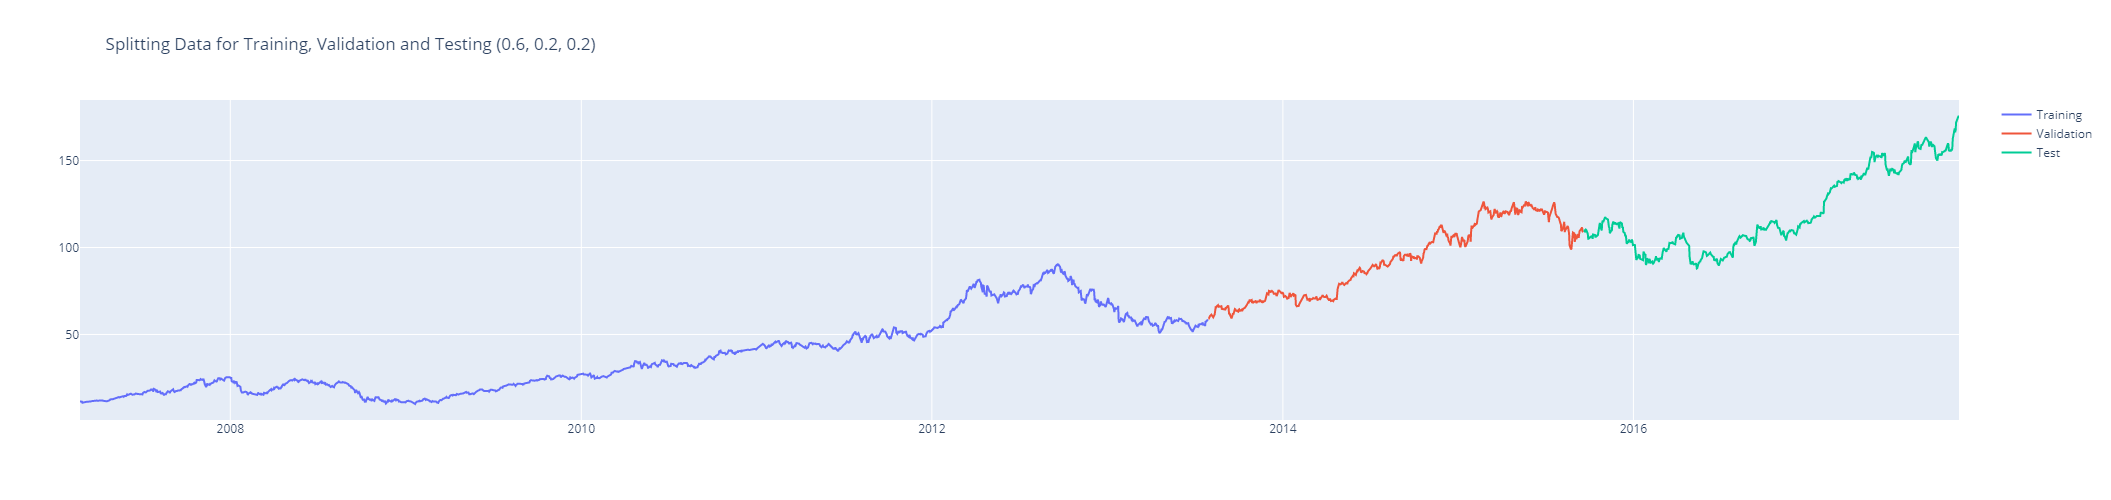

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=validation_df.Date, y=validation_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))

fig.update_layout(
    title = 'Splitting Data for Training, Validation and Testing (0.6, 0.2, 0.2)',
    height = 500,
    width = 800,
)
fig.show()
fig.write_image('data_split.png')

## Now we have our date ready to be used with some of sklearn's regressors.

Lets test with several regressors
1. Random Forest Regressor
2. KNeighbours Regressor
3. Support Vector Machine Regressor (RBF)
4. Histogram-based Gradient Boosting Regression Tree

In [17]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [29]:
# Initializing Models:

rfr = RandomForestRegressor(n_jobs = 4, criterion='mse', )
knr = KNeighborsRegressor(n_jobs=4)
hgbr = HistGradientBoostingRegressor(loss='least_squares', max_iter=100)

predictions = dict()

In [30]:
# Support Vector Regressor with RBF Kernel:
# We must scale data before using an SVR so we create a pipeline:

svr_pipe = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', gamma='auto', tol=1e-3, max_iter=-1),
)

In [35]:
# Train Our Regressors:
svr_pipe.fit(X_train, y_train)
rfr.fit(X_train, y_train)
knr.fit(X_train, y_train)
hgbr.fit(X_train, y_train)

HistGradientBoostingRegressor()

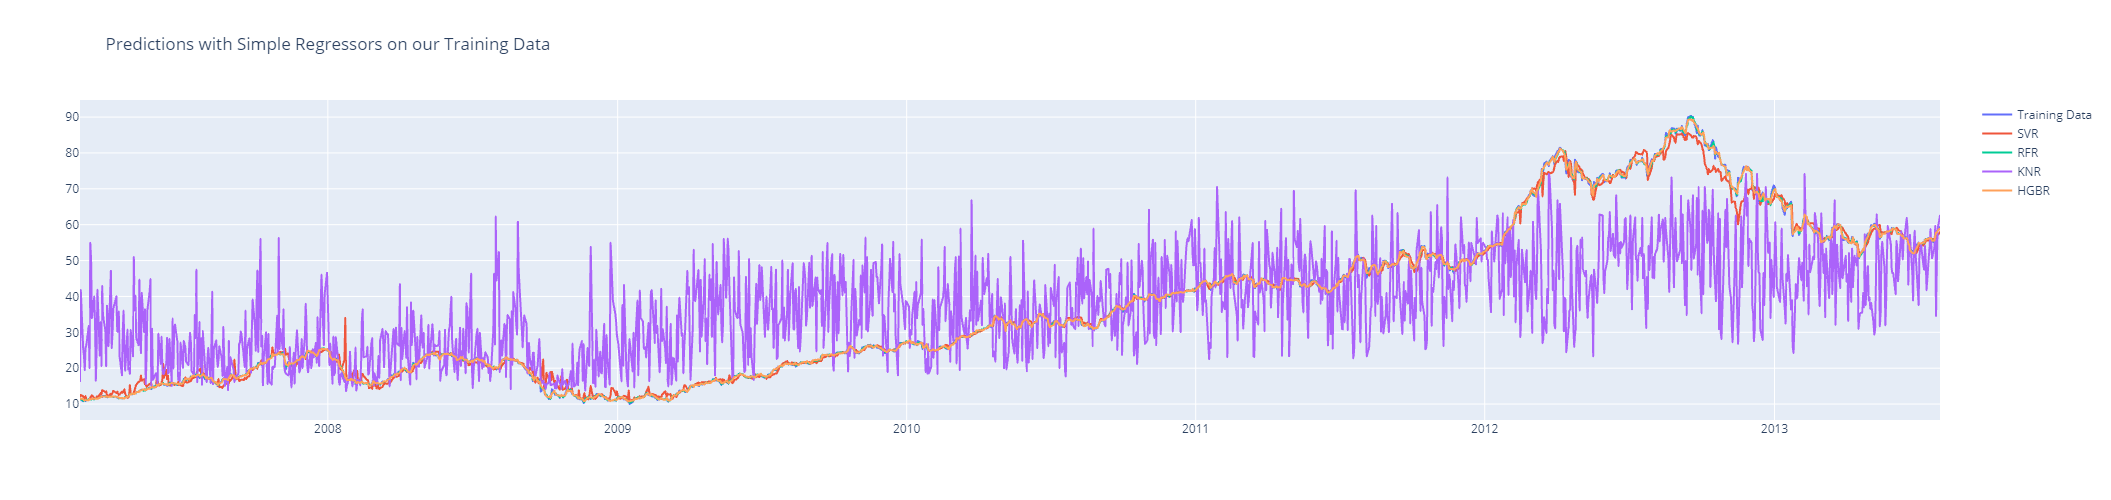

In [38]:
# Predict Training Data with Our Regressors
predictions['SVR'] = svr_pipe.predict(X_train)
predictions['RFR'] = rfr.predict(X_train)
predictions['KNR'] = knr.predict(X_train)
predictions['HGBR'] = hgbr.predict(X_train)

# Plot predicted vs real data:
fig = go.Figure()
fig.add_trace(go.Scattergl(x=train_df['Date'], y=y_train, name='Training Data'))

for key, val in predictions.items():
    fig.add_trace(go.Scattergl(x=train_df['Date'], y=val, name=key))
    
fig.update_layout(
    title='Predictions with Simple Regressors on our Training Data',
    height = 500,
    width = 800,
)

fig.show()

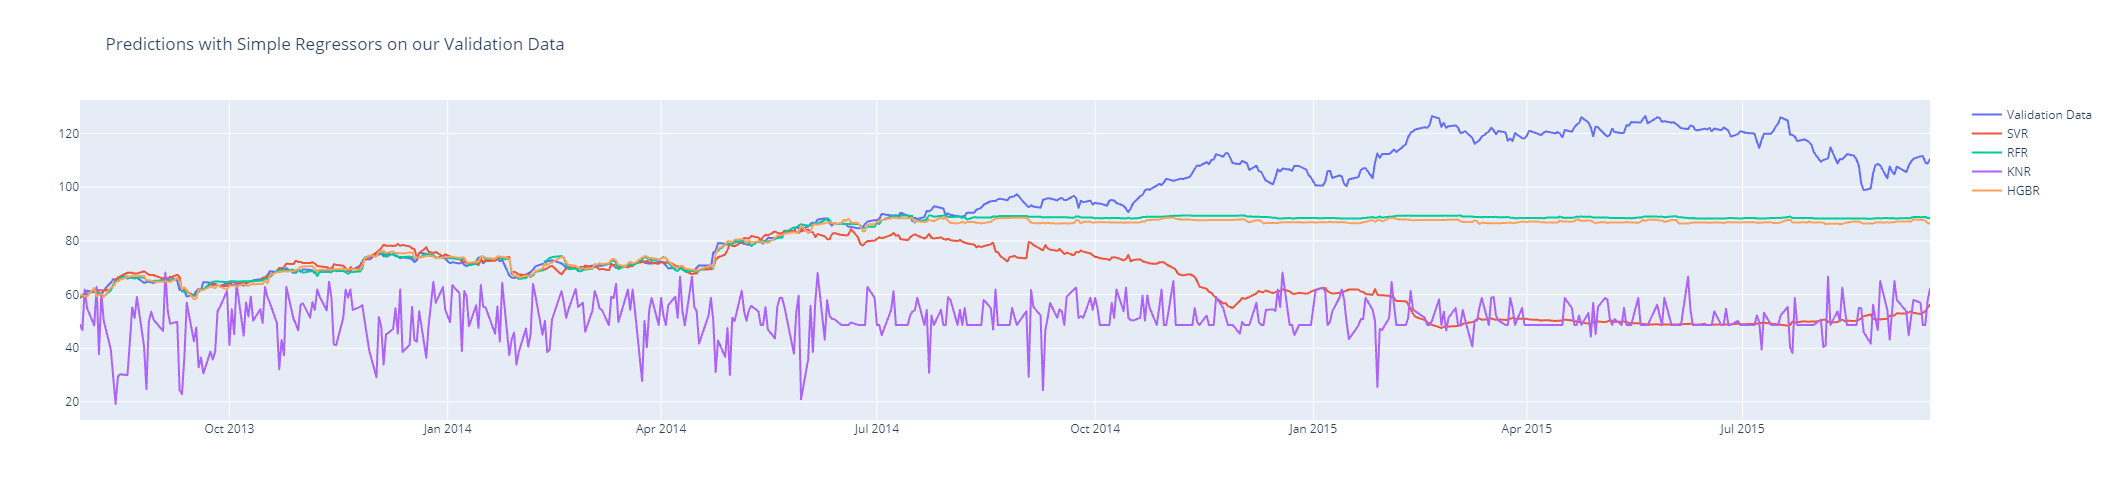

In [41]:
# Predict Validation Data with Our Regressors
predictions['SVR'] = svr_pipe.predict(X_validation)
predictions['RFR'] = rfr.predict(X_validation)
predictions['KNR'] = knr.predict(X_validation)
predictions['HGBR'] = hgbr.predict(X_validation)

# Plot predicted vs real data:
fig = go.Figure()
fig.add_trace(go.Scattergl(x=validation_df['Date'], y=y_validation, name='Validation Data'))

for key, val in predictions.items():
    fig.add_trace(go.Scattergl(x=validation_df['Date'], y=val, name=key))
    
fig.update_layout(
    title='Predictions with Simple Regressors on our Validation Data',
    height = 500,
    width = 800,
)

fig.show()

## Preliminary Conclusions

* We can see right away that our some algorithms are better suited to this data than others (i.e KNeihgbours is not suitable for this kind of task)
* We can also see that with our validation data, we are able to follow the trend right until June 2014 with most of our regressors.

This bring us to our next idea, a de-trender! A detrender utilizes linear regression to remove the underlying year over year trend so that our base ml model is only modelling the underlying pattern within our output data. 

1. Find the underlying trend in our data via linear regression
2. Remove the underlying trend so only residuals are left.
3. Use the residuals as training labels. 
4. Predict and re-trend to get real value of stock. 

In [82]:
result_stl.trend

Date
2007-02-22    18.179888
2007-02-23    18.182671
2007-02-26    18.185432
2007-02-27    18.188169
2007-02-28    18.190884
                ...    
2013-07-23    76.209072
2013-07-24    76.241403
2013-07-25    76.273695
2013-07-26    76.305949
2013-07-29    76.338164
Name: trend, Length: 1620, dtype: float64

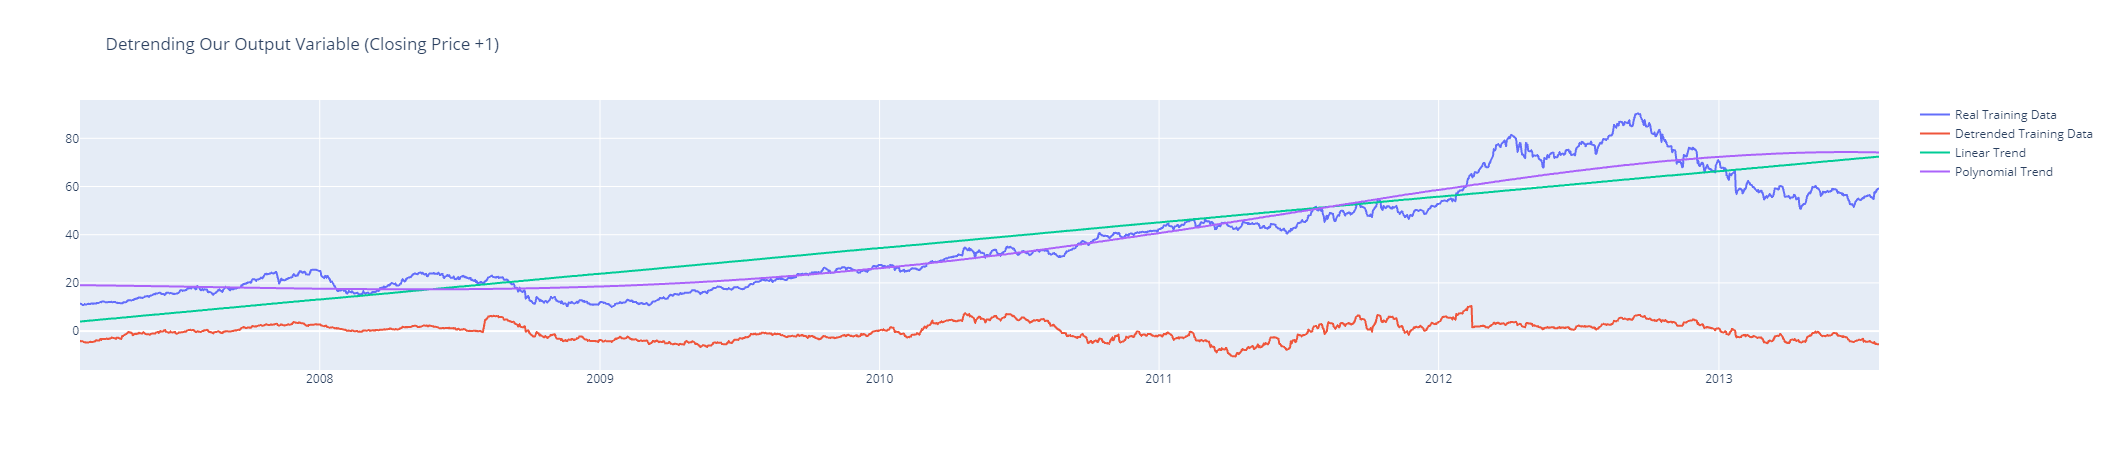

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# We call the Statsmodels.tsa.STL class -> Seasonal Trend Decomposition using LOESS
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.seasonal.STL.html

train_df_stl = train_df.set_index('Date')

result_stl = STL(train_df_stl['Close_Tomorrow'], period=365).fit()

# The result_stl stores several important things. We are primarily interested in the resid -> residuals and trend! 
# We are going to use the trend data to create a linear regression algorithm which will then be used in a pipeline
# Our x here will be the index of our data. For prediction, we must use the appropriate int index which will be based on the date we want to predict for. 
# Our starting date is 2007-02-22 -> comes from train_df
linear_trend_model = LinearRegression()
x_array_len = np.arange(0, len(train_df_stl), 1).reshape(-1, 1)
linear_trend_model.fit(x_array_len, result_stl.trend)
trend_linear = linear_trend_model.predict(x_array_len)

# We will also try polynomial regression to see if it shows a bette fit on the overall trend!
poly_trend_model = make_pipeline(
    PolynomialFeatures(4),
    LinearRegression()
)

poly_trend_model.fit(x_array_len, result_stl.trend)
trend_poly = poly_trend_model.predict(x_array_len)


fig = go.Figure()

fig.add_trace(go.Scattergl(x=train_df_stl.index, y=train_df_stl['Close_Tomorrow'].values, name= 'Real Training Data'))
fig.add_trace(go.Scattergl(x=result_stl.resid.index, y=result_stl.resid.values, name='Detrended Training Data'))
fig.add_trace(go.Scattergl(x=result_stl.resid.index, y=trend_linear, name='Linear Trend'))
fig.add_trace(go.Scattergl(x=result_stl.resid.index, y=trend_poly, name='Polynomial Trend'))
fig.update_layout(
    title='Detrending Our Output Variable (Closing Price +1)'
)
fig.show()

In [42]:
!pip install pystan

In [43]:
!pip install prophet

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\shary\.conda\envs\octo-test-1\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\shary\\AppData\\Local\\Temp\\pip-install-aatqnd1f\\prophet_2233f149f9d246ed8abdd63268f2ff31\\setup.py'"'"'; __file__='"'"'C:\\Users\\shary\\AppData\\Local\\Temp\\pip-install-aatqnd1f\\prophet_2233f149f9d246ed8abdd63268f2ff31\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\shary\AppData\Local\Temp\pip-wheel-vzjj399r'
       cwd: C:\Users\shary\AppData\Local\Temp\pip-install-aatqnd1f\prophet_2233f149f9d246ed8abdd63268f2ff31\
  Complete output (44 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib

  Running setup.py clean for prophet
  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730973 sha256=23eb8b12736dcc12de9f29dd09d189caf85da20ade23e92efcb16fa56a21946b
  Stored in directory: c:\users\shary\appdata\local\pip\cache\wheels\33\6b\a6\1d9dae2323750f635654952afc74aa8f2d982cded163f43895
Successfully built pymeeus
Failed to build prophet
    Running setup.py install for prophet: started
    Running setup.py install for prophet: finished with status 'error'



  creating build\lib\prophet
  creating build\lib\prophet\stan_model
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "C:\Users\shary\AppData\Local\Temp\pip-install-aatqnd1f\prophet_2233f149f9d246ed8abdd63268f2ff31\setup.py", line 150, in <module>
      long_description_content_type='text/markdown',
    File "C:\Users\shary\.conda\envs\octo-test-1\lib\site-packages\setuptools\__init__.py", line 153, in setup
      return distutils.core.setup(**attrs)
    File "C:\Users\shary\.conda\envs\octo-test-1\lib\distutils\core.py", line 148, in setup
      dist.run_commands()
    File "C:\Users\shary\.conda\envs\octo-test-1\lib\distutils\dist.py", line 966, in run_commands
      self.run_command(cmd)
    File "C:\Users\shary\.conda\envs\octo-test-1\lib\distutils\dist.py", line 985, in run_command
      cmd_obj.run()
    File "C:\Users\shary\.conda\envs\octo-test-1\lib\site-packages\wheel\bdist_wheel.py", line 299, in run
      self.run_command('build')
    

In [ ]:
# Prophet implementation

# LSTM Implementation

1. Split our data
2. Transform our data for an LSTM format (it must have the shape: [samples, timesteps, features]) -> in our case this will be [1620, 1, 12] for training set
3. 

In [38]:
# We have 2700 instances of our data -> 20% Test, 20% Validation and 60% Training set (540, 540, 1620)

X_train, y_train = X.iloc[:1620, :].values, y.iloc[:1620, :].values
X_validation, y_validation = X.iloc[1620:2160, :].values, y.iloc[1620:2160, :].values
X_test, y_test = X.iloc[2160:, :].values, y.iloc[2160:, :].values
dates_test = df_stock['Date'][2160:]

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_x = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler_x.fit_transform(X_train)
X_validation_scaled = scaler_x.transform(X_validation)
X_test_scaled = scaler_x.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_validation_scaled = scaler_y.transform(y_validation)
y_test_scaled = scaler_y.transform(y_test)


In [22]:
# Reshape our data:

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_validation_scaled = X_validation_scaled.reshape((X_validation_scaled.shape[0], 1, X_validation_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f'Train X Shape: {X_train_scaled.shape}\nValidation X Shape: {X_validation_scaled.shape}\nTest X Shape: {X_test_scaled.shape}')

Train X Shape: (1620, 1, 12)
Validation X Shape: (540, 1, 12)
Test X Shape: (540, 1, 12)


In [23]:
# Define our model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Train our network:
history = model.fit(X_train_scaled, y_train_scaled,
                   epochs=20,
                   batch_size=72,
                   validation_data=(X_validation_scaled, y_validation_scaled),
                   shuffle=False)

Epoch 1/20
23/23 - 4s - loss: 0.2193 - val_loss: 0.5795
Epoch 2/20
23/23 - 0s - loss: 0.1098 - val_loss: 0.1901
Epoch 3/20
23/23 - 0s - loss: 0.0977 - val_loss: 0.0762
Epoch 4/20
23/23 - 0s - loss: 0.0452 - val_loss: 0.0459
Epoch 5/20
23/23 - 0s - loss: 0.0231 - val_loss: 0.0254
Epoch 6/20
23/23 - 0s - loss: 0.0181 - val_loss: 0.0246
Epoch 7/20
23/23 - 0s - loss: 0.0395 - val_loss: 0.0368
Epoch 8/20
23/23 - 0s - loss: 0.0241 - val_loss: 0.0228
Epoch 9/20
23/23 - 0s - loss: 0.0283 - val_loss: 0.0671
Epoch 10/20
23/23 - 0s - loss: 0.0194 - val_loss: 0.0252
Epoch 11/20
23/23 - 0s - loss: 0.0345 - val_loss: 0.0333
Epoch 12/20
23/23 - 0s - loss: 0.0160 - val_loss: 0.0303
Epoch 13/20
23/23 - 0s - loss: 0.0196 - val_loss: 0.0423
Epoch 14/20
23/23 - 0s - loss: 0.0176 - val_loss: 0.0268
Epoch 15/20
23/23 - 0s - loss: 0.0197 - val_loss: 0.0288
Epoch 16/20
23/23 - 0s - loss: 0.0171 - val_loss: 0.0293
Epoch 17/20
23/23 - 0s - loss: 0.0124 - val_loss: 0.0325
Epoch 18/20
23/23 - 0s - loss: 0.0109 - 

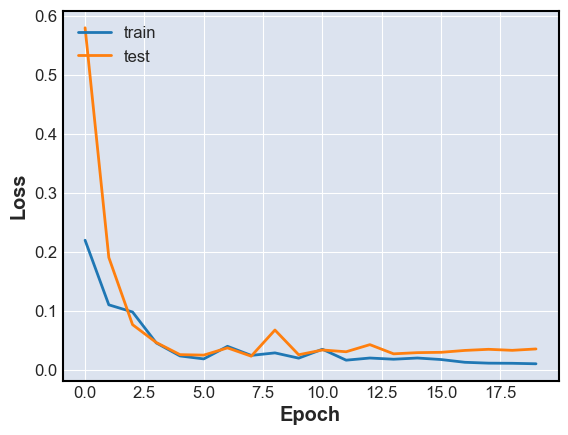

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [29]:
test_predictions = model.predict(X_test_scaled)

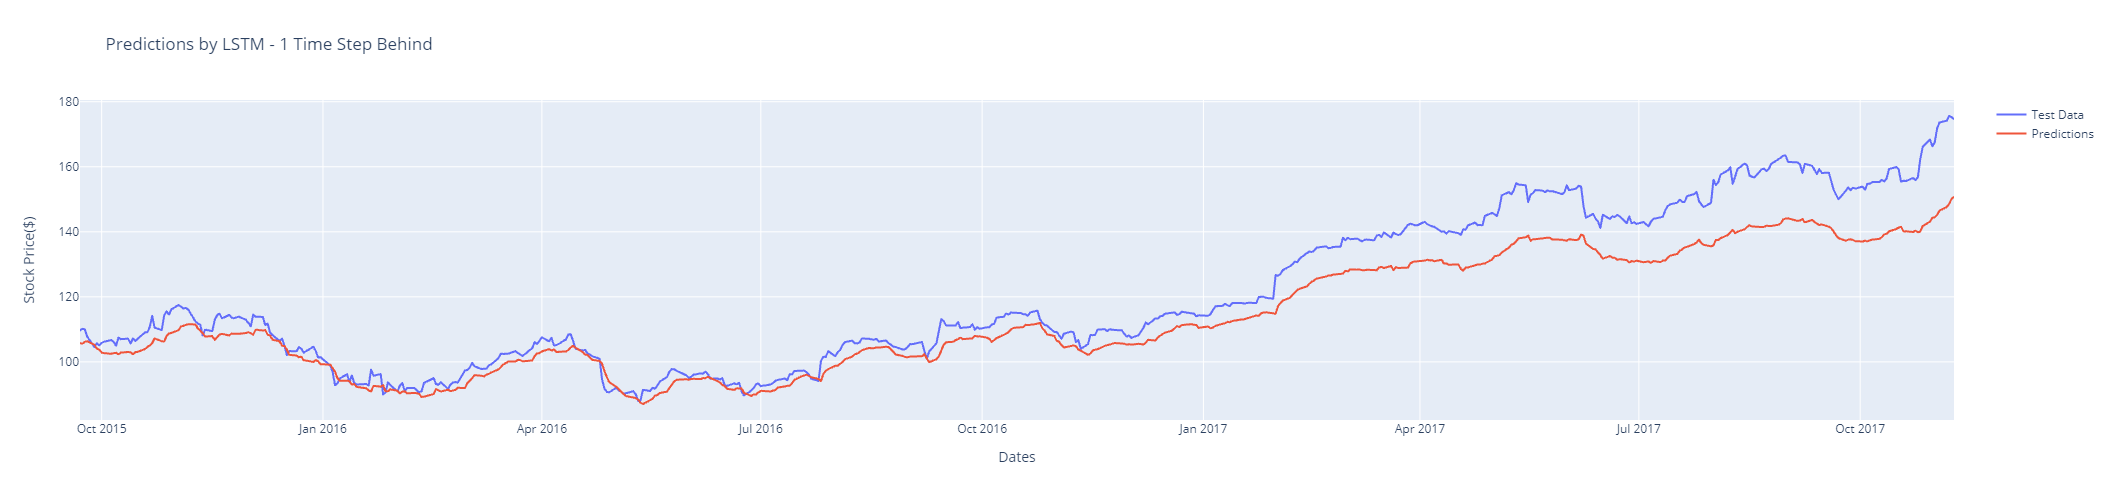

In [43]:
fig = go.Figure()

fig.add_trace(go.Scattergl(x=dates_test, y=y_test.ravel(), name='Test Data'))
fig.add_trace(go.Scattergl(x=dates_test, y=scaler_y.inverse_transform(test_predictions).ravel(), name='Predictions'))

fig.update_layout(
    title='Predictions by LSTM - 1 Time Step Behind',
    xaxis_title = 'Dates',
    yaxis_title = 'Stock Price($)',
    height = 500,
    width = 800,
)

fig.show()